In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [6]:
N=20 # 分割的份数
df = pd.read_excel("../data/merged_data_based_on_esg_contain_return_2009.xlsx")

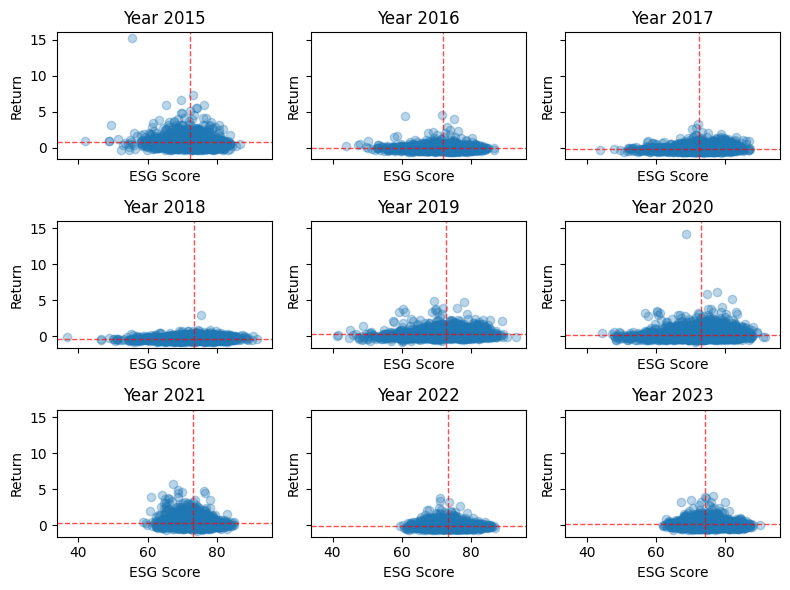

In [7]:
years = df['year'].unique()[-9:]

# 创建子图
fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharex=True,sharey=True)

axes = axes.flatten()
# 遍历每个年份并绘制子图
for i, year in enumerate(years):
    data_year = df[df['year'] == year]
    ax = axes[i]
    ax.scatter(data_year['esg_score'], data_year['return'],alpha=0.3)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('ESG Score')
    ax.set_ylabel('Return')

    mean_esg_score = data_year['esg_score'].mean()
    mean_return = data_year['return'].mean()
    ax.axhline(y=mean_return, color='red', linestyle='--', linewidth=1, alpha=0.7)  # 画出 y 轴均值的直线
    ax.axvline(x=mean_esg_score, color='red', linestyle='--', linewidth=1, alpha=0.7)  # 画出 x 轴均值的直线
    

plt.tight_layout()
plt.show()

In [8]:
df_pivot = df.pivot_table(index='year', columns='id', values='return')
df_pivot = df_pivot.dropna(axis=1)

# 按照 'id' 分组并计算 'esg_score' 的平均值
average_esg_score_2017_2022 = df[df["year"] != max(df["year"])].groupby('id')['esg_score'].mean()
average_esg_score_2023 = df[df['year'] == max(df["year"])].groupby('id')['esg_score'].mean()

# 对 esg_2017_2022 进行排序，以此为标准划分数据为10份
valid_ids = df_pivot.columns.tolist()
filtered_average_esg_score = average_esg_score_2017_2022.loc[valid_ids]
sorted_esg_score=filtered_average_esg_score.sort_values()

bins = pd.qcut(sorted_esg_score, q=N)

result = pd.DataFrame({
    'esg_score': sorted_esg_score,
    'quantile': bins
})

# 根据分割后的区间进行拆分
dfs = []
for _, group in result.groupby(bins):
    # 删除 'quantile' 列
    group = group.drop(columns=['quantile'])
    dfs.append(group)


C:\Users\11872\AppData\Local\Temp\ipykernel_14084\3639653457.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, group in result.groupby(bins):


In [9]:
# 创建一个空的 DataFrame 用于存放抽样结果
sampled_df = pd.DataFrame(columns=dfs[0].columns)

# 从每个分组中随机选择一行并添加到 sampled_df 中
for group_df in dfs:
    sampled_row = group_df.sample(n=1, random_state=40)  # 从每个分组中随机选择一行
    sampled_df = pd.concat([sampled_df, sampled_row])  # 将抽样结果添加到 sampled_df 中

esg_score_df=sampled_df
esg_score_array=np.array(esg_score_df.values)

selected_columns=esg_score_df.index.to_list()
returns = df_pivot.loc[:, selected_columns]

print(esg_score_df.head())
print(returns)

        esg_score
571     64.667143
600178  66.875000
600682  67.995000
516     68.774286
2215    69.550714
id      571       600178    600682    516       2215      860       600101  \
year                                                                         
2009  1.340000  2.927570  1.511295  1.756888  1.269929  0.622667  1.025346   
2010 -0.091516 -0.305175 -0.017758  0.265340  0.136368  0.294849  0.522659   
2011 -0.186120 -0.473459 -0.357267 -0.125887 -0.613087 -0.376745 -0.327562   
2012 -0.036530 -0.123577  0.177361 -0.106614 -0.035026 -0.033599  0.047177   
2013 -0.209371 -0.037106  0.413928  0.374436  0.842296  0.152539 -0.059064   
2014  0.344079  0.173411  0.402016  1.080959  0.190992  0.224650  0.090518   
2015  0.621094  0.844007  3.756385  0.801802  1.900345  0.144761  0.525798   
2016 -0.078290 -0.016919 -0.003620 -0.099271 -0.416450  0.037656 -0.154529   
2017 -0.288442 -0.391304  0.016545 -0.377523 -0.342058 -0.122099 -0.230164   
2018 -0.364815 -0.371346 -0.766101

C:\Users\11872\AppData\Local\Temp\ipykernel_14084\1687225728.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sampled_df = pd.concat([sampled_df, sampled_row])  # 将抽样结果添加到 sampled_df 中


In [10]:
risk_aversion=10
esg_coefficient=5/1000#2/1000
risk_free=0.015
# 分割数据集
returns_2017_to_2022 = returns[:-1]
returns_2023 = returns.tail(1)

expected_returns = returns_2017_to_2022.mean()
minimum_expected_return = min(expected_returns)
maximum_expected_return = max(expected_returns)
print("expected return min 20 stocks",min(expected_returns))
print("expected return max 20 stocks",max(expected_returns))
covariance_matrix = returns_2017_to_2022.cov(ddof=0)

def ptf_stats(weights):
    weights = np.array(weights)
    ptf_r = np.dot(expected_returns, weights)
    ptf_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    ptf_esg = (np.dot(esg_score_array.T, weights)/np.sum(weights))[0]
    return np.array([ptf_r, ptf_std, (ptf_r - risk_free) / ptf_std, ptf_esg])


#最大似然估计（MLE）
def objective_function(weights):
    return -np.dot(expected_returns, weights) + 1/2*risk_aversion* np.dot(np.dot(weights, covariance_matrix), weights)- esg_coefficient*np.dot(esg_score_array.T,weights)/np.sum(weights)

def min_var(weights):
    return np.sqrt(np.dot(weights, np.dot(covariance_matrix, weights)))

def sharpe_function(weights):
    return -np.dot(expected_returns, weights)/np.sqrt(np.dot(np.dot(weights, covariance_matrix), weights))

def efficient_frontier(start_r, end_r, steps):
    target_rs = np.linspace(start_r, end_r, steps)
    target_stds = []
    for r in target_rs:
        cons= ({'type': 'eq', 'fun': lambda weights: np.dot(expected_returns, weights) - r},
                {'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
        bnds = [(0, 1)] * len(expected_returns)
        res = minimize(min_var, x0=np.ones(len(expected_returns)) / len(expected_returns), bounds = bnds, constraints=cons)
        target_stds.append(res.fun)
    target_stds = np.array(target_stds)
    return target_rs, target_stds

def efficient_frontier_with_esg(start_r, end_r, steps, esg_target_score):
    target_rs = np.linspace(start_r, end_r, steps)
    target_stds = []
    for r in target_rs:
        cons= ({'type': 'eq', 'fun': lambda weights: np.dot(expected_returns, weights) - r},
                {'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
                {'type': 'eq', 'fun': lambda weights: np.dot(esg_score_array.T,weights)/np.sum(weights)-esg_target_score})
        bnds = [(0, 1)] * len(expected_returns)
        res = minimize(min_var, x0=np.ones(len(expected_returns)) / len(expected_returns), bounds = bnds, constraints=cons)
        target_stds.append(res.fun)
    target_stds = np.array(target_stds)
    return target_rs, target_stds


# Define a function to generate N number of random portfolios given a DataFrame of log returns
def generate_ptfs(returns, N):
    ptf_rs = []
    ptf_stds = []
    ptf_esgs=[]
    for i in range(N):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        ptf_rs.append(np.sum(returns.mean() * weights))
        ptf_stds.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights))))
        ptf_esgs.append(np.dot(esg_score_array.T,weights)/np.sum(weights))
    ptf_rs = np.array(ptf_rs)
    ptf_stds = np.array(ptf_stds)
    ptf_sharpes = (ptf_rs-risk_free) / ptf_stds
  
    return ptf_rs, ptf_stds,ptf_sharpes,ptf_esgs


expected return min 20 stocks -0.0017900714285714314
expected return max 20 stocks 0.3730930714285715


In [11]:
optimizer = minimize(objective_function, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints={'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})

mle_weights=optimizer.x
print("The top five weights",sorted(mle_weights)[-5:])
print("objective function value: ",optimizer.fun)
print("Status:",optimizer.success)

def portfolio_metrics_test(weights, returns):
    portfolio_return = np.dot(weights, returns.mean())
    return portfolio_return

print("Test sample by 2023")
test_returns=portfolio_metrics_test(mle_weights, returns_2023)
print("MLE Portfolio by all stocks - Expected Return: {:.4f}".format(test_returns))

def objective_function_group_return(weights,return_df,esg_score_array):
    return -np.dot(return_df.mean(), weights) + 1/2*risk_aversion* np.dot(np.dot(weights, return_df.cov(ddof=0)), weights)- esg_coefficient*np.dot(esg_score_array.T,weights)/np.sum(weights)


test_returns_group=[]
for index,df in enumerate(dfs):
    esg_score_array_group=np.array(df.values) #128
    selected_columns_group=df.index.to_list()
    returns_group = df_pivot.loc[:, selected_columns_group]
    returns_group_2017_to_2022=returns_group[:-1]
    returns_group_2023=returns_group.tail(1)
    expected_returns_group_2017_to_2022=returns_group_2017_to_2022.mean()
    
    optimizer_group = minimize(objective_function_group_return, x0=np.ones(len(expected_returns_group_2017_to_2022)) / len(expected_returns_group_2017_to_2022),
                               args=(returns_group_2017_to_2022,esg_score_array_group),
                        bounds=[(0, 1)] * len(expected_returns_group_2017_to_2022),constraints={'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
    
    mle_weights_group=optimizer_group.x
    
    test_returns_group.append(portfolio_metrics_test(mle_weights_group, returns_group_2023))

    print("Test sample by 2023 (group {})".format(index))
    print("MLE Portfolio by all stocks - Expected Return: {:.4f}".format(portfolio_metrics_test(mle_weights_group, returns_group_2023)))


The top five weights [2.1748574101623807e-16, 0.01347142591916538, 0.015516535236255504, 0.050960705217961866, 0.9200513336266166]
objective function value:  -0.3652356679556057
Status: True
Test sample by 2023
MLE Portfolio by all stocks - Expected Return: 0.2836
Test sample by 2023 (group 0)
MLE Portfolio by all stocks - Expected Return: -0.0415
Test sample by 2023 (group 1)
MLE Portfolio by all stocks - Expected Return: 0.0380
Test sample by 2023 (group 2)
MLE Portfolio by all stocks - Expected Return: -0.2249
Test sample by 2023 (group 3)
MLE Portfolio by all stocks - Expected Return: 0.1615
Test sample by 2023 (group 4)
MLE Portfolio by all stocks - Expected Return: -0.2078
Test sample by 2023 (group 5)
MLE Portfolio by all stocks - Expected Return: -0.0417
Test sample by 2023 (group 6)
MLE Portfolio by all stocks - Expected Return: 0.0965
Test sample by 2023 (group 7)
MLE Portfolio by all stocks - Expected Return: -0.0096
Test sample by 2023 (group 8)
MLE Portfolio by all stocks 

[56.419 66.195 67.686 68.445 69.231 69.925 70.6   71.101 71.599 72.083
 72.584 73.068 73.503 74.105 74.56  75.154 75.759 76.324 77.265 78.637]
[66.195 67.686 68.445 69.231 69.925 70.6   71.101 71.599 72.083 72.584
 73.068 73.503 74.105 74.56  75.154 75.759 76.324 77.265 78.637 83.036]


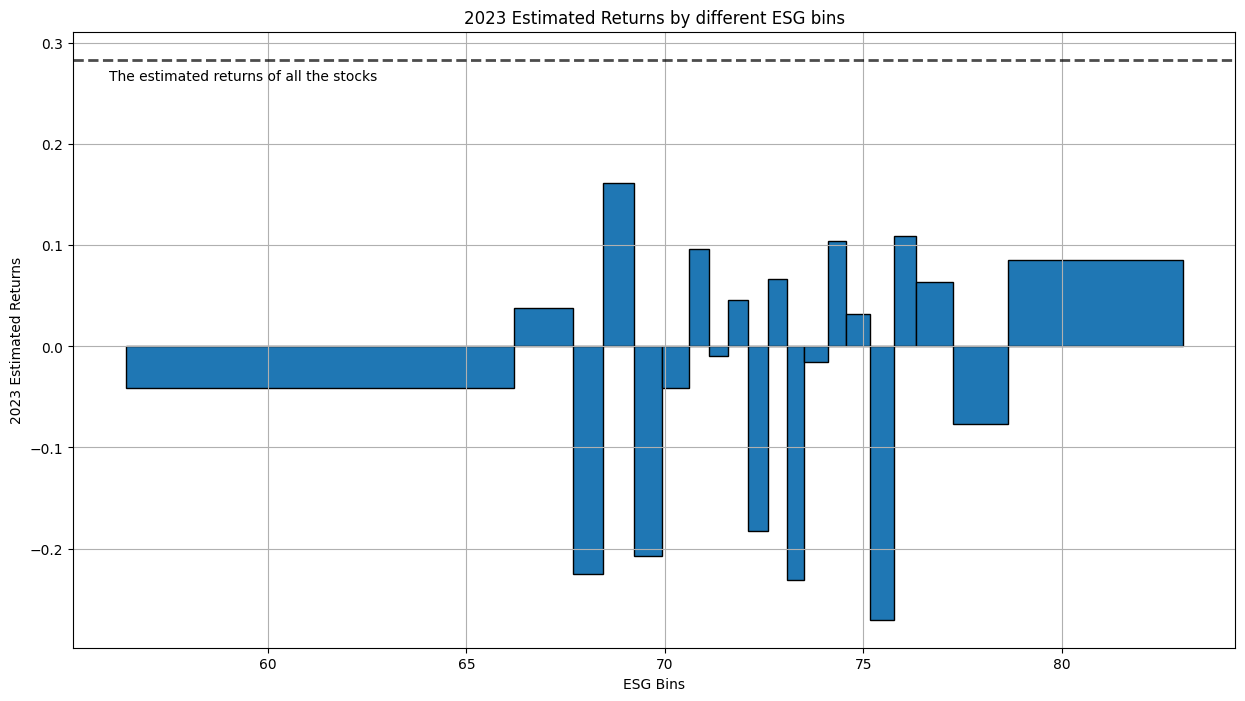

In [12]:
bin_upper_limits = np.array(sorted([interval.right for interval in set(bins.values)]))
bin_lower_limits = np.array(sorted([interval.left for interval in set(bins.values)]))
print(bin_lower_limits)
print(bin_upper_limits)
plt.figure(figsize=(15,8))
plt.grid(True)
plt.axhline(y=test_returns, color='black', linestyle='--', linewidth=2, alpha=0.7)
plt.text(56, test_returns-0.01, 'The estimated returns of all the stocks', verticalalignment='top', horizontalalignment='left')
plt.bar(bin_lower_limits, test_returns_group, width=(bin_upper_limits-bin_lower_limits), align='edge', edgecolor='black')
plt.xlabel('ESG Bins')
plt.ylabel('2023 Estimated Returns')
plt.title('2023 Estimated Returns by different ESG bins')
plt.show()

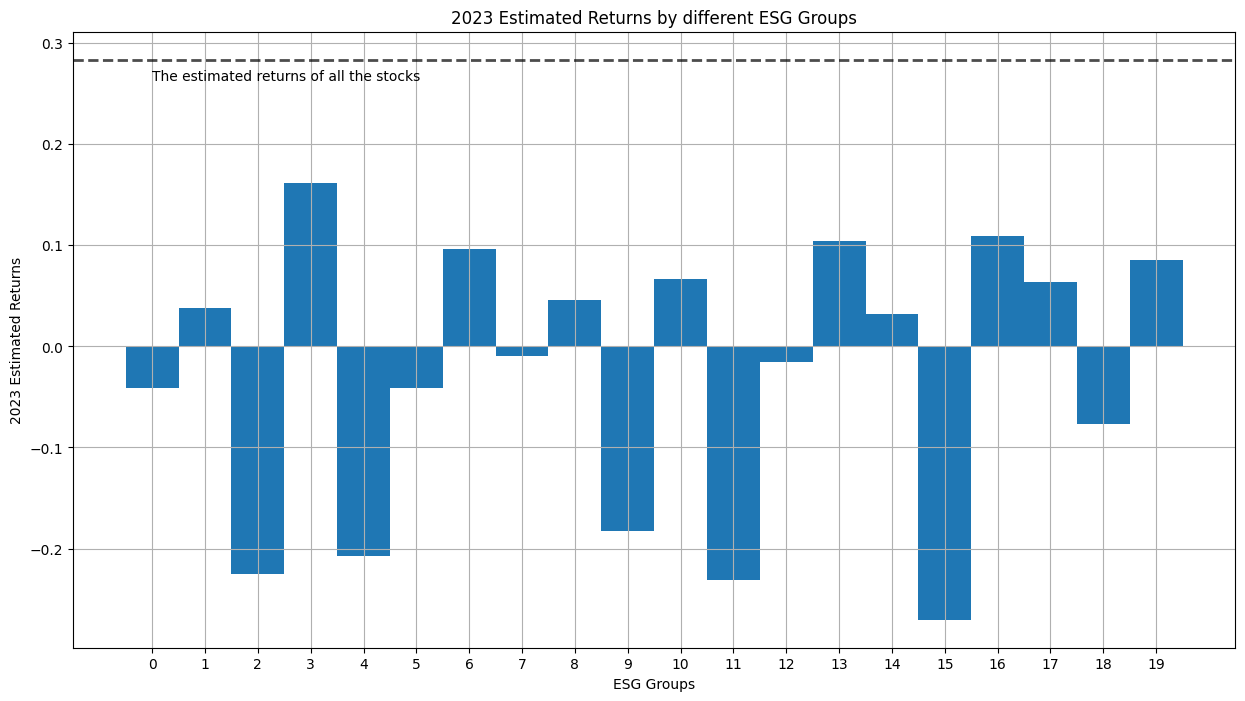

In [13]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.axhline(y=test_returns, color='black', linestyle='--', linewidth=2, alpha=0.7)
plt.text(0, test_returns-0.01, 'The estimated returns of all the stocks', verticalalignment='top', horizontalalignment='left')
# plt.bar(bin_lower_limits, test_returns_group, width=(bin_upper_limits-bin_lower_limits), align='edge', edgecolor='black')
x_values = range(len(test_returns_group))

y_values = test_returns_group

plt.bar(x_values, y_values, width=1)  # 设置柱状图的宽度为0.5
plt.xlabel('ESG Groups')
plt.ylabel('2023 Estimated Returns')
plt.title('2023 Estimated Returns by different ESG Groups')
plt.xticks(x_values, x_values)
plt.show()

Text(0.5, 1.0, '5000 Randomly Generated Portfolios In The Risk-Return Space')

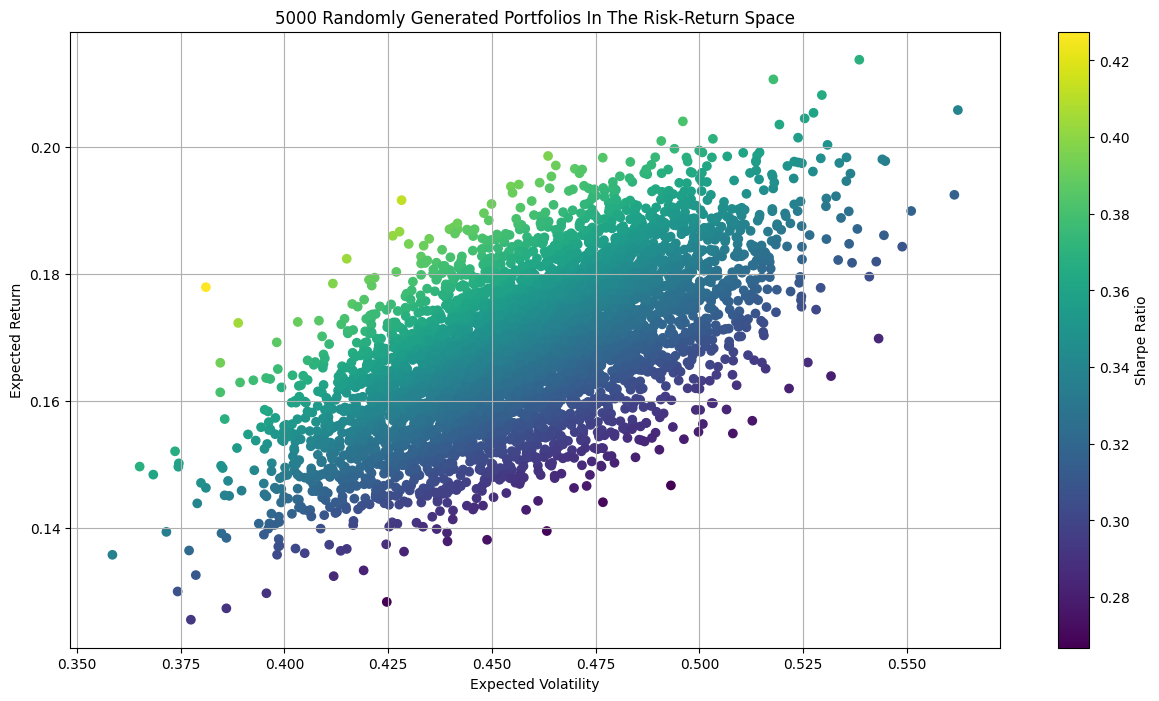

In [14]:
ptf_rs, ptf_stds, ptf_sharpes, ptf_esgs= generate_ptfs(returns_2017_to_2022, 5000)

plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=ptf_sharpes, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('5000 Randomly Generated Portfolios In The Risk-Return Space')

In [15]:
opts = minimize(sharpe_function, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},       
                        ])

opts_72 = minimize(sharpe_function, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  
                            {'type': 'eq', 'fun': lambda weights: np.dot(esg_score_array.T,weights)-72},      
                        ])

opts_75 = minimize(sharpe_function, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  
                            {'type': 'eq', 'fun': lambda weights: np.dot(esg_score_array.T,weights)-75},      
                        ])


opt_var = minimize(min_var, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},       
                        ])


opt_var_72 = minimize(min_var, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  
                            {'type': 'eq', 'fun': lambda weights: np.dot(esg_score_array.T,weights)-72},])

opt_var_75 = minimize(min_var, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  
                            {'type': 'eq', 'fun': lambda weights: np.dot(esg_score_array.T,weights)-75}] )



In [16]:
target_rs, target_stds = efficient_frontier(minimum_expected_return, maximum_expected_return, 50)
target_rs_esg_72,target_stds_esg_72 = efficient_frontier_with_esg(minimum_expected_return, maximum_expected_return, 50, 72)
target_rs_esg_75,target_stds_esg_75 = efficient_frontier_with_esg(minimum_expected_return, maximum_expected_return, 50, 75)

sharpe values of tangent portfolios 0.6404735067565461 0.6116972457247989 0.6382327516117149


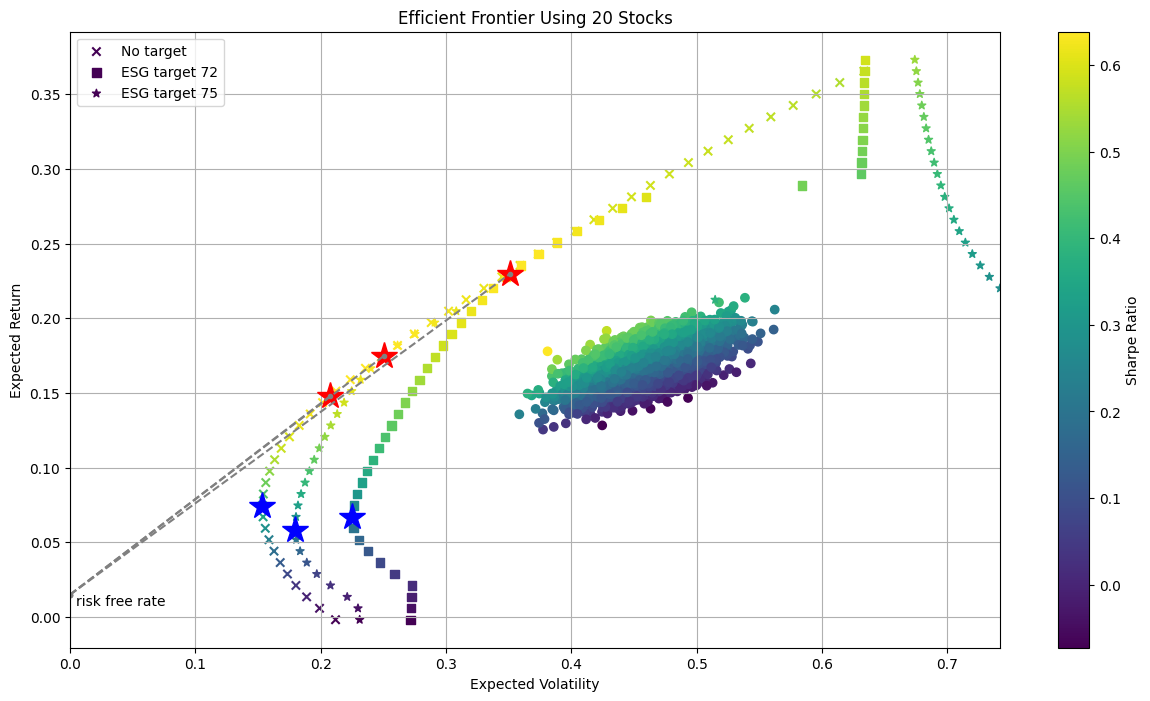

In [17]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=(ptf_rs - risk_free)/ptf_stds, marker='o')
plt.scatter(target_stds, target_rs, c=(target_rs - risk_free)/target_stds, marker='x',label='No target')
plt.scatter(target_stds_esg_72, target_rs_esg_72, c=(target_rs_esg_72 - risk_free)/target_stds_esg_72, marker=',',label="ESG target 72")
plt.scatter(target_stds_esg_75, target_rs_esg_75, c=(target_rs_esg_75 - risk_free)/target_stds_esg_75, marker='*',label="ESG target 75")

plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opts_72['x'])[1], ptf_stats(opts_72['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opts_75['x'])[1], ptf_stats(opts_75['x'])[0], 'r*', markersize=20.0)

plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.plot(ptf_stats(opt_var_72['x'])[1], ptf_stats(opt_var_72['x'])[0], 'b*', markersize=20.0)
plt.plot(ptf_stats(opt_var_75['x'])[1], ptf_stats(opt_var_75['x'])[0], 'b*', markersize=20.0)

plt.plot([0, ptf_stats(opts["x"])[1]], [risk_free, ptf_stats(opts["x"])[0]],  linestyle='--', color='grey',marker='.')
plt.plot([0, ptf_stats(opts_72["x"])[1]], [risk_free, ptf_stats(opts_72["x"])[0]],  linestyle='--', color='grey',marker='.')
plt.plot([0, ptf_stats(opts_75["x"])[1]], [risk_free, ptf_stats(opts_75["x"])[0]],  linestyle='--', color='grey',marker='.')


print("sharpe values of tangent portfolios",ptf_stats(opts["x"])[2],ptf_stats(opts_72["x"])[2],ptf_stats(opts_75["x"])[2])
plt.text(0+0.005, risk_free, 'risk free rate', verticalalignment='top', horizontalalignment='left')

plt.grid(True)
plt.legend()
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0, max(target_stds_esg_75))
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier Using {} Stocks'.format(N))
plt.show()

In [18]:
x_lower = min(esg_score_array)[0]
x_upper = max(esg_score_array)[0]
x_range = np.linspace(x_lower, x_upper, 200)
print(x_lower)
print(x_upper)
# esg_target_val=60

sharpe_list=[]
for x in x_range:
    optimizer = minimize(sharpe_function, x0=np.ones(len(expected_returns)) / len(expected_returns),
                        bounds=[(0, 1)] * len(expected_returns),constraints=[
                            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  
                            {'type': 'eq', 'fun': lambda weights: np.dot(esg_score_array.T,weights)-x},      
                        ])
    sharpe_list.append(-optimizer.fun)
max_sharpe_index = sharpe_list.index(max(sharpe_list))
max_sharpe = max(sharpe_list)

64.66714285714286
79.21071428571429


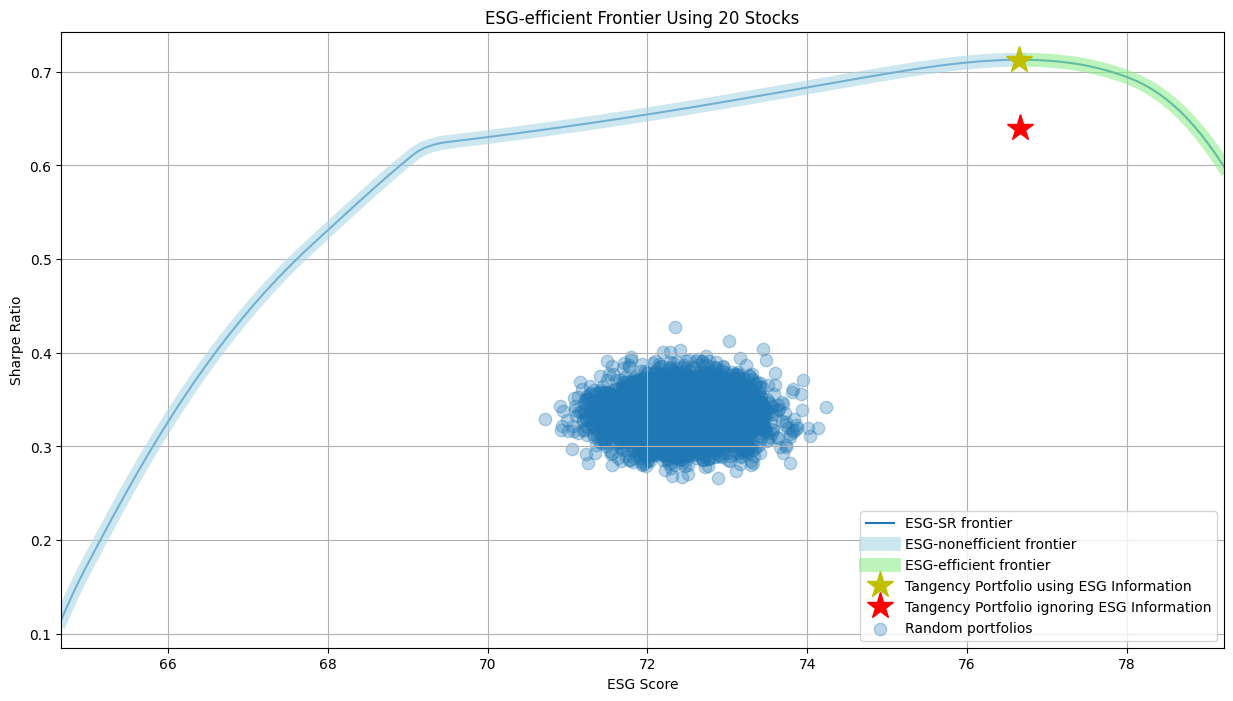

with ERG information 76.65279971284997 0.7128940745239679
without ERG information 76.66479097961353 0.6404735067565461


In [19]:
plt.figure(figsize=(15, 8))

plt.plot(x_range,sharpe_list,label="ESG-SR frontier")
plt.plot(x_range[:max_sharpe_index+1], sharpe_list[:max_sharpe_index+1], linewidth=10, alpha=0.6,color='lightblue', label="ESG-nonefficient frontier")
plt.plot(x_range[max_sharpe_index+1:], sharpe_list[max_sharpe_index+1:], linewidth=10, alpha=0.6,color='lightgreen', label="ESG-efficient frontier ")

plt.plot(x_range[max_sharpe_index], max_sharpe, 'y*', markersize=20.0,label="Tangency Portfolio using ESG Information")

plt.plot(ptf_stats(opts['x'])[3], ptf_stats(opts['x'])[2], 'r*', markersize=20.0,label="Tangency Portfolio ignoring ESG Information")
plt.grid(True)
plt.xlabel('ESG Score')
plt.ylabel('Sharpe Ratio')
plt.xlim(min(x_range),max(x_range))
plt.scatter(ptf_esgs, ptf_sharpes, s=80,alpha=0.3,marker='o',label="Random portfolios")
plt.legend()
plt.title('ESG-efficient Frontier Using {} Stocks'.format(N))
plt.show()
print("with ERG information",x_range[max_sharpe_index],max_sharpe)
print("without ERG information",ptf_stats(opts['x'])[3], ptf_stats(opts['x'])[2])